# Autocorrelation analysis of Berlin by median price of airbnbs/neighborhood

In [108]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lp
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [109]:
ref = pd.read_csv(
    "../data - AirBnb/listings.csv.gz", compression='gzip', on_bad_lines='skip')
df = gpd.read_file(
    "../data - AirBnb/neighbourhoods.geojson"
)


ref['price'] = ref['price'].str.replace('$', '').str.replace(',', '').astype(float)
ref = ref[ref['price'] < 1000]

median = ref['price'].median()

ref['neighbourhood'] = ref['neighbourhood_cleansed']

In [110]:
# average price per neighbourhood
ref = ref.groupby('neighbourhood').mean(numeric_only=True)[['price']]
ref.head()

,price
neighbourhood,
Adlershof,110.270270
Albrechtstr.,91.820000
Alexanderplatz,139.857931
Allende-Viertel,44.500000
Alt Treptow,117.943396


In [111]:
df.set_index('neighbourhood', inplace=True)

df = df.merge(ref, left_index=True, right_index=True)

In [112]:
df.head()

,neighbourhood_group,geometry,price
neighbourhood,,,
Adlershof,Treptow - Köpenick,"MULTIPOLYGON (((13.55429 52.42581, 13.55424 52...",110.270270
Albrechtstr.,Steglitz - Zehlendorf,"MULTIPOLYGON (((13.32681 52.46139, 13.32700 52...",91.820000
Alexanderplatz,Mitte,"MULTIPOLYGON (((13.40559 52.52967, 13.40721 52...",139.857931
Allende-Viertel,Treptow - Köpenick,"MULTIPOLYGON (((13.58666 52.44096, 13.58587 52...",44.500000
Alt Treptow,Treptow - Köpenick,"MULTIPOLYGON (((13.43966 52.48991, 13.43967 52...",117.943396


<Axes: >

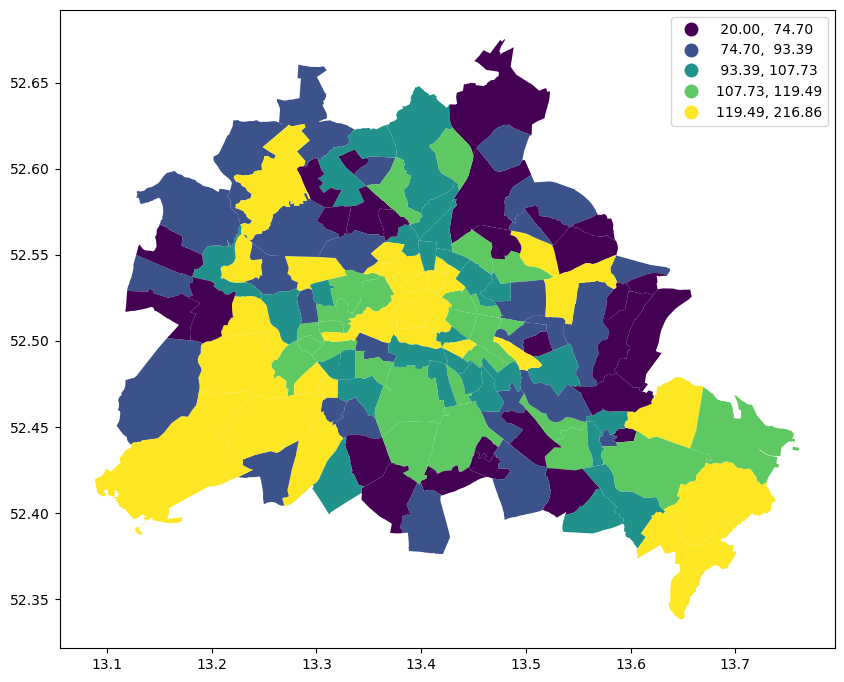

In [113]:
df.plot(column='price', legend=True, figsize=(10, 10), scheme='quantiles')

In [114]:
# convert multi-polygons to polygons. Luckily, for this dataset, all of the multi polygons contain just one polygon
df['geometry'] = df['geometry'].apply(lambda x: x.geoms[0])

wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'


/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":


In [115]:
y = df['price']
ylag = lp.weights.lag_spatial(wq, y)


In [116]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

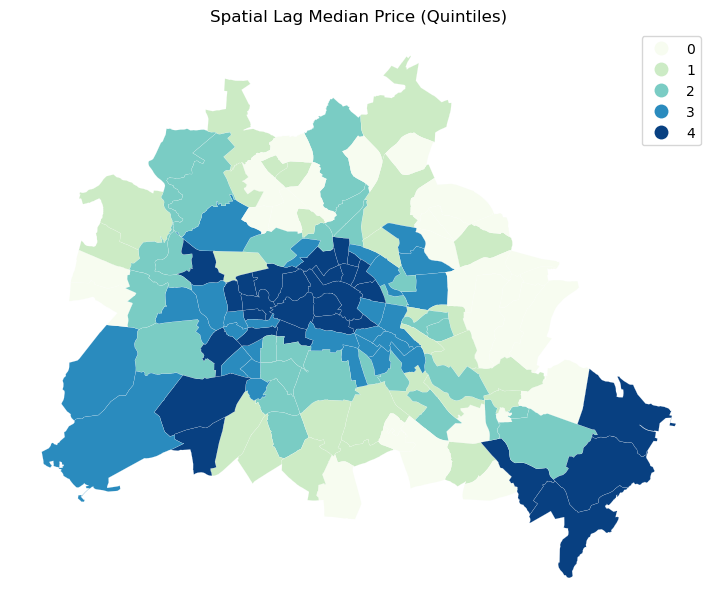

In [117]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,
        k=5, cmap='GnBu', linewidth=0.1, ax=ax,
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()


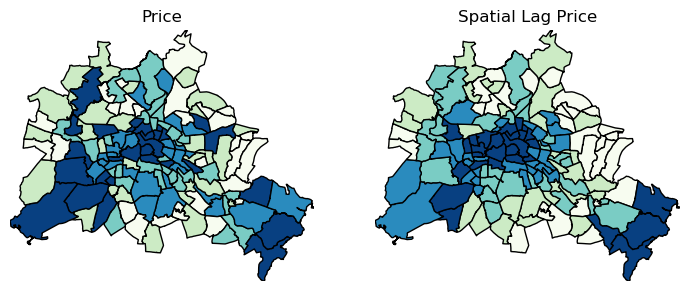

In [118]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='price', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [119]:
yb = y > y.median()
sum(yb)

69

In [120]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

<Axes: >

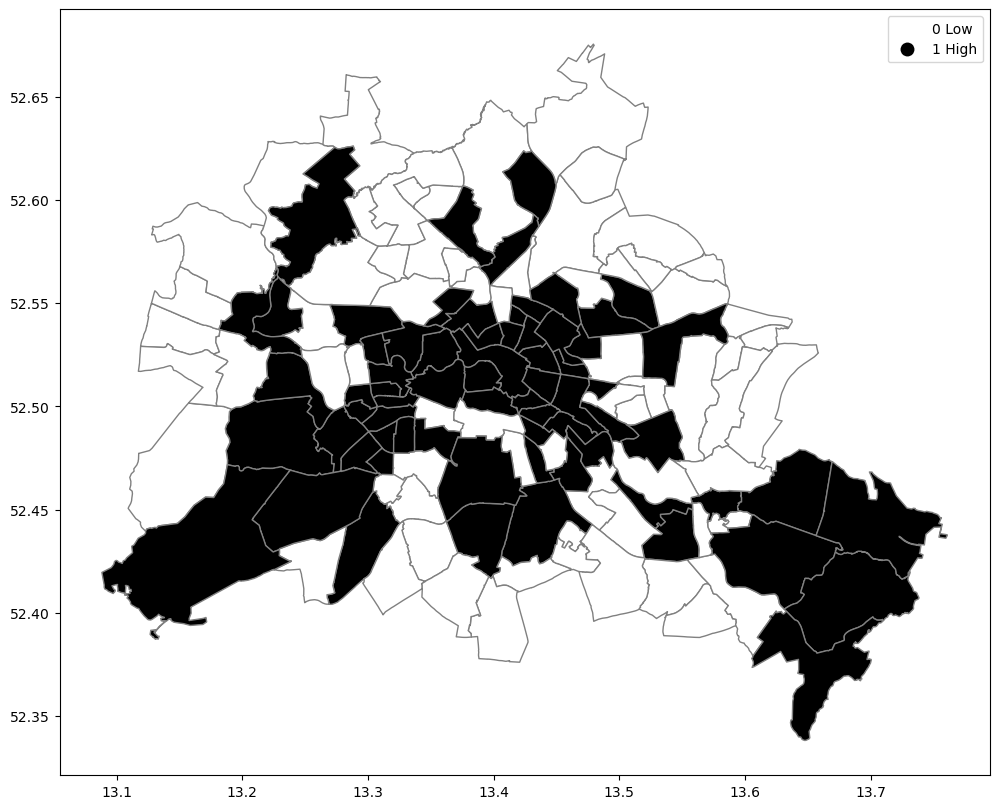

In [121]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)


In [122]:
np.random.seed(12345)
import esda


In [123]:
wq.transform = 'r'
lag_price = lp.weights.lag_spatial(wq, df['price'])

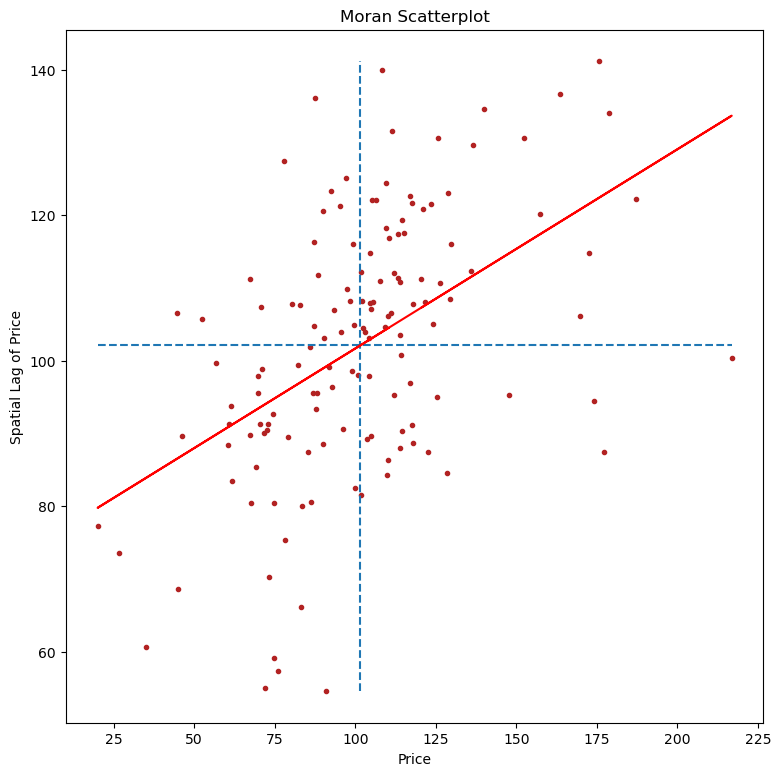

In [124]:
price = df['price']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


In [125]:
li = esda.moran.Moran_Local(y, wq)


In [126]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4


In [127]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]


# Hot spots / cold spots

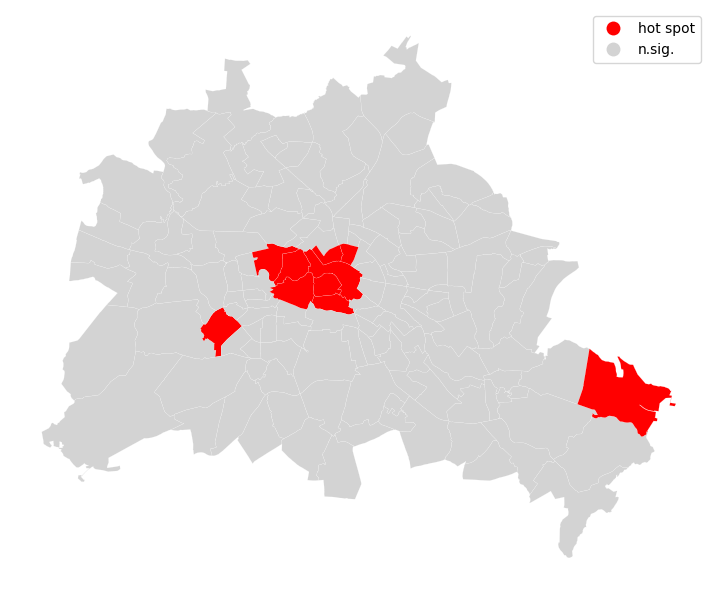

In [128]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()


In [129]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]


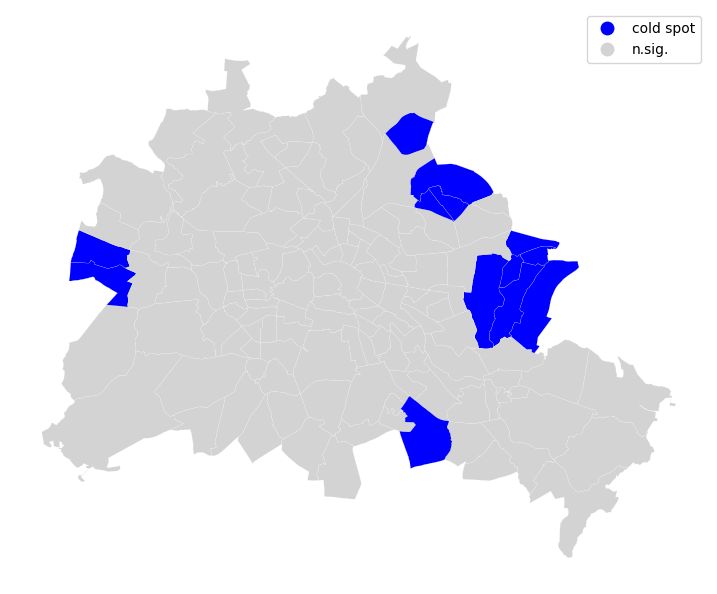

In [130]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()